# P-Center Problem

*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

Hakimi (1964) introduced the absolute center problem to locate a police station or a hospital such that the maximum distance of the station to a set of communities connected by a highway system is minimized. Hakimi (1965) generalizes the absolute center problem to the p-center problem. Given a set $X_p=\{x_1,\ldots,x_p\}$ of $p$ points in graph $G$, the distance $d(X_p, v_j)$ between $X_p$ and node $v_j$ is computed as $min_{i=1,\ldots,n}{w_jd(v_j, X_p)}$ is minimized.

Daskin (2013) proposed a Mixed Integer Programming formulation to discrete p-center problem written as:

$\begin{array} \displaystyle \textbf{Minimize} & W && (1)\\
\displaystyle \textbf{Subject to:} & \sum_{j}{y_{ij} = 1} & \forall i & (2) \\
            & \sum_{j}{x_{j} = p} && (3) \\
            & y_{ij} \leq x_{j} & \forall i,j & (4) \\
            & W \geq \sum_{j}{d_{ij}y_{ij}} & \forall i & (5)\\
            & x_{j} \in \{0,1\} & \forall j & (6) \\ 
            & y_{ij} \geq 0 & \forall i,j & (7)\\
            \end{array}$

$\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing nodes of the network as demand} \\
& & j & \small = & \textrm{index referencing nodes of the network as potential facility sites} \\
& & d_{ij} & \small = & \textrm{shortest distance or travel time between nodes} i \textrm{and} j \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & x_j & \small = & \begin{cases} 
          1, \text{if locate at candidate site } j \\
          0, \text{otherwise} \\
       \end{cases} \\
& & y_{ij} & \small = & \textrm{fraction of demand at node } i \textrm{that is served by a facility at node} j \\
& & W & \small = & \textrm{maximum distance between a demand node and the nearest facility} \\
\end{array}$


This tutorial solves PCenter using `spopt.locate.PCenter` instance that depends on a array 2D representing the costs between facilities candidate sites and demand points. For that it uses a lattice 10x10 with simulated points to calculate the costs.


In [1]:
from spopt.locate import PCenter
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

Since the model needs a distance cost matrix we should define some variables. In the comments, it's defined what these variables are for but solver. The solver, assigned below as `pulp.PULP_CBC_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface as Gurobi or CPLEX see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [3]:
CLIENT_COUNT = 100 # quantity demand points
FACILITY_COUNT = 5 # quantity supply points

P_FACILITIES = 4

# Random seeds for reproducibility
CLIENT_SEED = 5 
FACILITY_SEED = 6 

solver = pulp.PULP_CBC_CMD(msg=False) # see solvers available in pulp reference

## Lattice 10x10

Create lattice 10x10 with 9 vertical lines in interior.

In [4]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform spaghetti instance to geopandas geodataframe.

In [5]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

Plotting the network created by spaghetti we can verify that it seems a district with quarters and streets.

<AxesSubplot:>

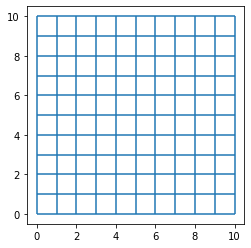

In [6]:
street.plot()

## Simulate points in a network

The function `simulated_geo_points` simulates points inside a network. In this case, it uses a lattice network 10x10 created by using spaghetti package.
Below we use the function defined above and simulate the points inside lattice bounds.

In [7]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 100 client and 5 facility points we can see that the function generates dummy points to an area of 10x10 which is the area created by our lattice created on previous cells.

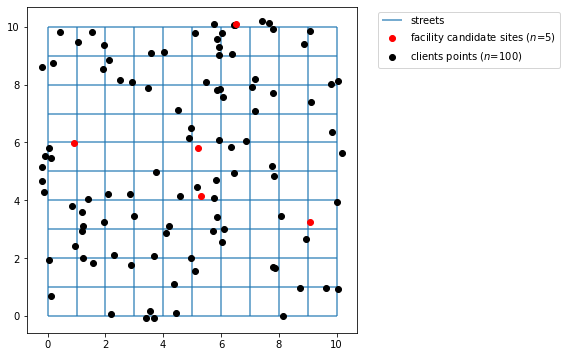

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
client_points.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## Transform simulated points to real points

To use cost matrix or geodataframes we have to pay attention in some details. The client and facility points simulated don't belong to network, so if we calculate the distances now we are supposed to receive a wrong result. Before calculating distances we snap points to the networok and then calculate the distances.

Below we snap points that is not spatially belong to network and create new real points geodataframes.

In [9]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

Now the plot seems more organized as the points belong to network. 
The network created is plotted below with facility points and clients points:

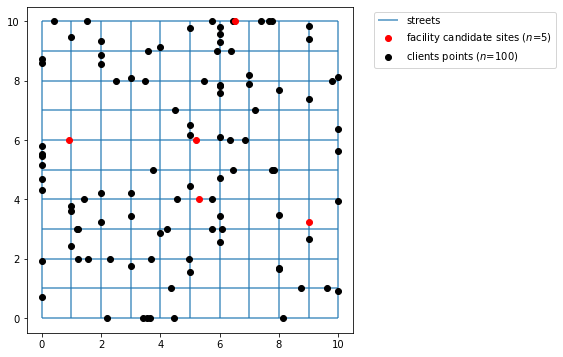

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
clients_snapped.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## Calculating the cost matrix 

Calculate distance between clients and facilities.

In [11]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

The expected result here is a Dijkstra distance between clients and facilities points, so we our case an array 2D 100x5.

In [12]:
cost_matrix

array([[12.60302601,  3.93598651,  8.16571655,  6.04319467,  5.65607701],
       [13.10096347,  4.43392397,  8.66365401,  6.54113213,  5.15813955],
       [ 6.9095462 ,  4.2425067 ,  2.47223674,  0.34971486,  5.34955682],
       [ 2.98196832,  7.84581224,  3.45534114,  3.57786302,  6.25374871],
       [ 7.5002892 ,  6.32806975,  4.55779979,  6.43527791, 11.75939222],
       [ 0.60209077, 11.42987132,  5.03940023,  7.16192211,  9.8378078 ],
       [ 5.37335867,  6.20113923,  2.43086927,  4.30834738,  9.6324617 ],
       [ 5.40801577,  5.41976478,  3.02929369,  1.15181557,  4.85108725],
       [ 3.68807115,  8.51585171,  2.12538061,  4.24790249,  7.94717417],
       [14.22503627,  4.60274429,  9.78772681,  7.66520493,  4.98931924],
       [10.32521229,  4.99225179,  7.38272288,  9.260201  , 14.58431531],
       [ 6.65436171,  7.98732222,  5.59685112,  3.719373  ,  2.58135531],
       [11.55510375,  1.11193575,  7.11779429,  5.37988496, 10.70399927],
       [10.90832519,  1.75871431,  6.4

With ``PCenter.from_cost_matrix`` we model the PCenter problem to minimize the maximum distance between a client and a facility point using 4 facility sites and the cost matrix calculated previously.

In [13]:
pcenter_from_cost_matrix = PCenter.from_cost_matrix(cost_matrix, p_facilities=P_FACILITIES)
pcenter_from_cost_matrix = pcenter_from_cost_matrix.solve(solver)

Expected result is an instance of PCenter.

In [14]:
pcenter_from_cost_matrix

## Using GeoDataFrame

In [15]:
clients_snapped

,id,geometry,comp_label
0,0,POINT (2.00000 8.85562),0
1,1,POINT (2.00000 9.35355),0
2,2,POINT (5.00000 6.16214),0
3,3,POINT (7.76544 5.00000),0
4,4,POINT (3.00000 1.75230),0
...,...,...,...
95,95,POINT (0.00000 4.30248),0
96,96,POINT (6.00000 3.42781),0
97,97,POINT (2.20274 0.00000),0
98,98,POINT (7.40431 10.00000),0


With ``PCenter.from_geodataframe`` we model the PCenter problem to minimize the maximum distance between a client and a facility point using 4 facility sites and geodataframes without calculating the cost matrix previously.

In [16]:
pcenter_from_geodataframe = PCenter.from_geodataframe(
    clients_snapped, 
    facilities_snapped, 
    "geometry", 
    "geometry", 
    p_facilities=P_FACILITIES,
    distance_metric="euclidean"
)
pcenter_from_geodataframe = pcenter_from_geodataframe.solve(solver)

Expected result is an instance of PCenter.

In [17]:
pcenter_from_geodataframe

## Plotting the results

The cell below describe the plotting of the results. For each method from PCenter class (from_cost_matrix, from_geodataframe) there is a plot displaying the facility site that was selected with a star colored and the points covered with the same color. Sometimes the demand points will be colored with not expected colors, it represents the coverage overlapping.

In [19]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

dv_colors = [
    "darkcyan",
    "mediumseagreen",
    "cyan",
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
] 

def plot_results(model, facility_points):
    arr_points = []
    fac_sites = []
    
    for i in range(FACILITY_COUNT):
        if model.fac2cli[i]:

            geom = client_points.iloc[model.fac2cli[i]]['geometry']
            arr_points.append(geom)
            fac_sites.append(i)

    fig, ax = plt.subplots(figsize=(6, 6))
    legend_elements = []

    street.plot(ax=ax, alpha=1, color='black', zorder=1)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='black',
        label='streets',
    ))

    facility_points.plot(ax=ax, color='brown', marker="*", markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={FACILITY_COUNT})'
    ))

    for i in range(len(arr_points)):
        gdf = geopandas.GeoDataFrame(arr_points[i])

        label = f"coverage_points by y{fac_sites[i]}"
        legend_elements.append(Patch(facecolor=dv_colors[i], edgecolor="k", label=label))

        gdf.plot(ax=ax, zorder=3, alpha=0.7, edgecolor="k", color=dv_colors[i], label=label)
        facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200 * 3.0,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor=dv_colors[i])
        
        legend_elements.append(mlines.Line2D(
            [],
            [],
            color=dv_colors[i],
            marker="*",
            ms=20 / 2,
            markeredgecolor="k",
            linewidth=0,
            alpha=0.8,
            label=f"y{fac_sites[i]} facility selected",
        ))

    plt.title("P-Center", fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

### PCenter built from cost matrix

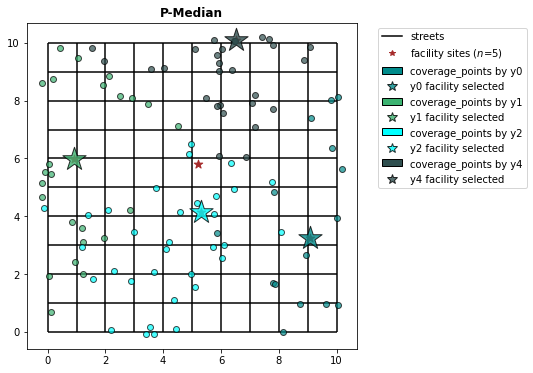

In [20]:
pcenter_from_cost_matrix.facility_client_array()
plot_results(pcenter_from_cost_matrix, facility_points)

### PCenter from geodataframes

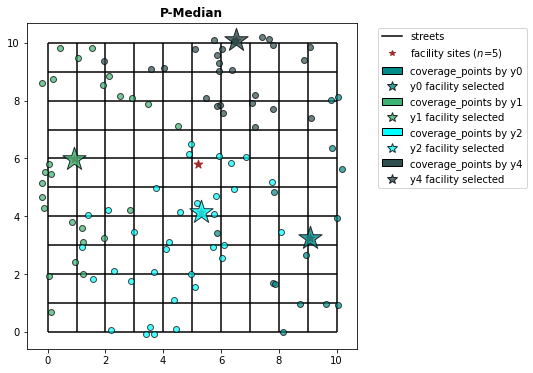

In [21]:
pcenter_from_geodataframe.facility_client_array()
plot_results(pcenter_from_geodataframe, facility_points)

## References

- [Hakimi, S. L. (1965). Optimum Distribution of Switching Centers in a Communication Network and Some Related Graph Theoretic Problems. Operations Research, 13(3), 462–475.](doi:10.1287/opre.13.3.462) 

- [Hakimi, S. L. “Optimum Locations of Switching Centers and the Absolute Centers and Medians of a Graph.” Operations Research, vol. 12, no. 3, 1964, pp. 450–459.](https://doi.org/10.1287/opre.12.3.450)

- [Calik H., Labbé M., Yaman H. (2015) p-Center Problems. In: Laporte G., Nickel S., Saldanha da Gama F. (eds) Location Science. Springer, Cham.](https://doi.org/10.1007/978-3-319-13111-5_4)

- [Network and Discrete Location Models, Algorithms, and Applications - Mark S. Daskin](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118537015)
